In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
labels_df = pd.read_csv("./drive/MyDrive/CS4220_mp2/CS4220/datasets/labels.csv", index_col=0)
print(labels_df.shape)
labels_df.head()

(860663, 3)


,genome_name,rl,rq
0,staphylococcus_aureus,962,98.26
0,staphylococcus_aureus,962,98.26
1,staphylococcus_aureus,704,90.25
2,staphylococcus_aureus,2617,96.20
3,staphylococcus_aureus,4169,99.38


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


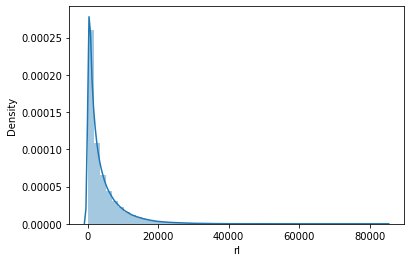

In [3]:
sns.distplot(labels_df[labels_df["genome_name"] == "decoy"]["rl"])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


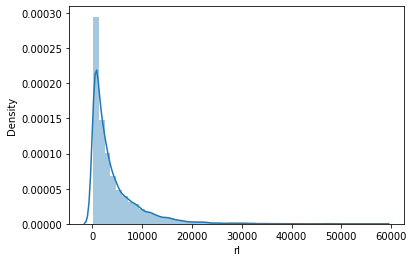

In [4]:
sns.distplot(labels_df[labels_df["genome_name"] != "decoy"]["rl"])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


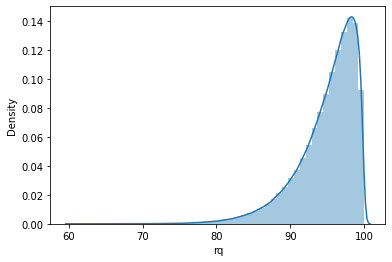

In [5]:
sns.distplot(labels_df[labels_df["genome_name"] == "decoy"]["rq"])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


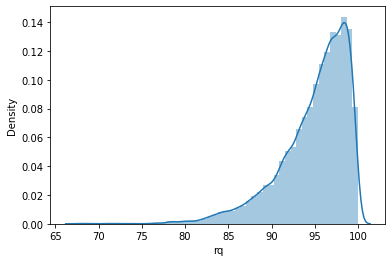

In [6]:
sns.distplot(labels_df[labels_df["genome_name"] != "decoy"]["rq"])

In [7]:
labels_df["genome_name"].value_counts()

decoy                          815912
burkholderia_pseudomallei        8558
pseudomonas_aeruginosa           7568
mycobacterium_ulcerans           6786
mycobacterium_tuberculosis       5265
staphylococcus_aureus            3412
corynebacterium_ulcerans         2962
corynebacterium_diphtheriae      2885
neisseria_gonorrhoeae            2637
streptococcus_pneumoniae         2600
staphylococcus_pyogenes          2078
Name: genome_name, dtype: int64

In [8]:
decoy_idx = list(labels_df[labels_df["genome_name"] == "decoy"].index)
pathogen_idx = list(labels_df[labels_df["genome_name"] != "decoy"].index)
print("Number of decoys = " , len(decoy_idx))
print("Number of pathogens = " , len(pathogen_idx))

Number of decoys =  815912
Number of pathogens =  44751


In [9]:
max(pathogen_idx) # implies after the first 100,000 rows the rest are decoys

62466

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels_df["encoded_labels"] = le.fit_transform(labels_df["genome_name"])
labels_df

,genome_name,rl,rq,encoded_labels
0,staphylococcus_aureus,962,98.26,8
0,staphylococcus_aureus,962,98.26,8
1,staphylococcus_aureus,704,90.25,8
2,staphylococcus_aureus,2617,96.20,8
3,staphylococcus_aureus,4169,99.38,8
...,...,...,...,...
860657,decoy,248,95.85,3
860658,decoy,6472,91.61,3
860659,decoy,1779,89.71,3
860660,decoy,3496,92.07,3


In [11]:
import torch
import torch.nn as nn
import torch.functional as F

In [12]:
class MLP(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim):
    super().__init__()
    self.lin1 = nn.Linear(input_dim, hidden_dim)
    self.lin2 = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    x = nn.ReLU()(self.lin1(x))
    x = self.lin2(x)
    return x

In [13]:
net = MLP(2080, 11, 512)
batch_size = 1000
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

In [14]:
count = 0
for chunk in pd.read_csv("./drive/MyDrive/CS4220_mp2/CS4220/datasets/perfect_reads_6mer.gz", sep="\t", header=None, chunksize=100000):
  chunk.drop(2080, axis = 1, inplace=True)
  my_labels_df = labels_df["encoded_labels"].values[chunk.index[0]:chunk.index[-1] + 1]
  chunk["labels"] = my_labels_df
  sample_size = 2078
  df_train = chunk.groupby('labels').apply(lambda x: x.sample(sample_size))
  df_train.reset_index(drop=True, inplace=True)
  inputs = torch.Tensor(df_train.iloc[:, 0:2080].values)
  shuffled_idx = torch.randperm(df_train.shape[0])
  for c in range(0, df_train.shape[0], batch_size):
    idx = shuffled_idx[c:c+batch_size]
    optimizer.zero_grad()
    out = net(inputs[idx])
    labels = torch.from_numpy(df_train["labels"].iloc[idx].values)
    loss = criterion(out, labels)
    loss.backward()
    optimizer.step()
  count += 1
  break
  if count % 10 == 0:
    print("Loss is ", end = "-")
    print(loss.item())
    break
    
    

In [15]:
!unzip -o /content/drive/MyDrive/CS4220_mp2/CS4220/datasets/validation-20220402T110325Z-001.zip

Archive:  /content/drive/MyDrive/CS4220_mp2/CS4220/datasets/validation-20220402T110325Z-001.zip
  inflating: validation/val7_labels.txt  
  inflating: validation/val8_labels.txt  
  inflating: validation/val10_labels.txt  
  inflating: validation/val9_labels.txt  
  inflating: validation/val6_labels.txt  
  inflating: validation/val3_labels.txt  
  inflating: validation/val5_abundance.txt  
  inflating: validation/val3_abundance.txt  
  inflating: validation/val4_labels.txt  
  inflating: validation/val1_labels.txt  
  inflating: validation/val9_abundance.txt  
  inflating: validation/val10_abundance.txt  
  inflating: validation/val6_abundance.txt  
  inflating: validation/val1_abundance.txt  
  inflating: validation/val5_labels.txt  
  inflating: validation/val7_abundance.txt  
  inflating: validation/val2_labels.txt  
  inflating: validation/val4_abundance.txt  
  inflating: validation/val2_abundance.txt  
  inflating: validation/val8_abundance.txt  
  inflating: validation/genome_r

In [16]:
! unzip -o /content/drive/MyDrive/CS4220_mp2/CS4220/datasets/val_11_16_data.zip -d validation/
! unzip -o /content/drive/MyDrive/CS4220_mp2/CS4220/datasets/val_11_16_labels.zip -d validation/

Archive:  /content/drive/MyDrive/CS4220_mp2/CS4220/datasets/val_11_16_data.zip
  inflating: validation/val15_6mer.gz  
  inflating: validation/val13_6mer.gz  
  inflating: validation/val14_6mer.gz  
  inflating: validation/val12_6mer.gz  
  inflating: validation/val16_6mer.gz  
  inflating: validation/val11_6mer.gz  
Archive:  /content/drive/MyDrive/CS4220_mp2/CS4220/datasets/val_11_16_labels.zip
  inflating: validation/val15_labels.txt  
  inflating: validation/val14_labels.txt  
  inflating: validation/val11_labels.txt  
  inflating: validation/val16_labels.txt  
  inflating: validation/val13_labels.txt  
  inflating: validation/val12_labels.txt  


In [17]:
def precision_per_patient(patient_id, preds):
    df_true = pd.read_csv('./validation/val{}_labels.txt'.format(patient_id))
    tp, fp=0,0
    print('my predition(s) for patient {}:'.format(patient_id))
    print(preds)
    print('true pathogen')
    print(df_true['true_label'].values)
    for item in np.unique(preds):
        if item in df_true['true_label'].values:
            tp+=1
        else:
            fp+=1
    return tp/(tp+fp)

In [18]:
# identify non-decoys in each of the validation sets
all_precision = []
threshold = 0.3
for patient_id in range(1,17):
    print('predicting for patient {}'.format(patient_id))
    df_test = pd.read_csv('./validation/val{}_6mer.gz'.format(patient_id), header=None, sep='\t')
    
    #regr.predict relies on argmax, thus predict to every single read and you will end up with many false positives
    y_pred = net(torch.from_numpy(df_test.iloc[:,:-1].values).float())
    # print(y_pred)
    #we can use regr.predict_proba to find a good threshold and predict only for case where the model is confident.
    #here I apply 0.999 as the cutoff for my predictions, let's see how well my model will behave...
    y_predprob = torch.softmax(y_pred, dim = 1).detach()
    # print(y_predprob.shape)
    preds = (torch.argmax(y_predprob,  dim=1)).numpy()
    non_decoy_idx = np.where(preds != 3)[0]
    # print(non_decoy_idx)
    #we get only predictions larger than the threshold and if there is more than one, we take the argmax again
    # final_predictions = le.inverse_transform(np.unique([np.argmax(item) for item in y_predprob  if len(np.where(item>= threshold)[0]) >=1]
    #                                              ))
    final_predictions = le.inverse_transform(np.unique(preds))
    precision = precision_per_patient(patient_id, final_predictions)
    print('precision: {}'.format(precision))
    all_precision.append(precision)
    
    


predicting for patient 1
my predition(s) for patient 1:
['staphylococcus_aureus']
true pathogen
['staphylococcus_aureus']
precision: 1.0
predicting for patient 2
my predition(s) for patient 2:
['staphylococcus_aureus']
true pathogen
['staphylococcus_pyogenes']
precision: 0.0
predicting for patient 3
my predition(s) for patient 3:
['staphylococcus_aureus']
true pathogen
['burkholderia_pseudomallei' 'corynebacterium_ulcerans']
precision: 0.0
predicting for patient 4
my predition(s) for patient 4:
['staphylococcus_aureus']
true pathogen
['pseudomonas_aeruginosa']
precision: 0.0
predicting for patient 5
my predition(s) for patient 5:
['staphylococcus_aureus']
true pathogen
['corynebacterium_diphtheriae']
precision: 0.0
predicting for patient 6
my predition(s) for patient 6:
['staphylococcus_aureus']
true pathogen
['streptococcus_pneumoniae']
precision: 0.0
predicting for patient 7
my predition(s) for patient 7:
['staphylococcus_aureus']
true pathogen
['mycobacterium_ulcerans']
precision: 0

In [19]:
print([ 'patient {}: {}'.format(c,item) for c, item in enumerate(all_precision, start=1)], 'avg: {}'.format(np.mean(all_precision)))

['patient 1: 1.0', 'patient 2: 0.0', 'patient 3: 0.0', 'patient 4: 0.0', 'patient 5: 0.0', 'patient 6: 0.0', 'patient 7: 0.0', 'patient 8: 0.0', 'patient 9: 0.0', 'patient 10: 0.0', 'patient 11: 0.0', 'patient 12: 0.0', 'patient 13: 0.0', 'patient 14: 0.0', 'patient 15: 0.0', 'patient 16: 0.0'] avg: 0.0625
